# DE effects plots 

In [8]:
import anndata
import pandas as pd
import numpy as np
import scanpy as sc

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text


We define some helper functions

In [9]:
from typing import List, Union, Optional

def get_DE_results_long(
    adata_de: anndata.AnnData, 
    targets: Union[List[str], None] = None, 
    genes: Union[List[str], None] = None, 
    effect_estimates: Union[str, List[str]] = ['log_fc', 'zscore'],
    signif_estimate: Union[None, str] = 'adj_p_value',
    signif_alpha = 0.1,
    gene_id_col: str = 'gene_name',
    target_id_col: str = 'contrast',
    target_metadata_cols: List[str] = ['condition', 'contrast']
    ):
    """
    Extract differential expression results from AnnData object in long table format.
    
    Parameters
    ----------
    adata_de : AnnData
        AnnData object containing DE results
    targets : List[str] or None
        List of target contrasts to include, or None for all
    genes : List[str] or None
        List of genes to include, or None for all
    effect_estimates : str or List[str]
        Names of layers containing effect estimates (e.g., log fold changes, z-scores)
    signif_estimate : str or None
        Name of layer containing significance values, or None if not needed
    signif_alpha : float
        Significance threshold for filtering
    gene_id_col : str
        Column in var containing gene identifiers
    target_id_col : str
        Column in obs containing target identifiers
    target_metadata_cols : List[str]
        Columns in obs to include as target metadata in the result
        
    Returns
    -------
    pd.DataFrame
        Long-format dataframe with DE results
    """
    # Convert effect_estimates to list if it's a string
    if isinstance(effect_estimates, str):
        effect_estimates = [effect_estimates]
    
    # Filter targets if specified
    if targets is not None:
        target_mask = adata_de.obs[target_id_col].isin(targets)
        adata_subset = adata_de[target_mask]
    else:
        adata_subset = adata_de
    
    # Filter genes if specified
    if genes is not None:
        gene_mask = adata_subset.var[gene_id_col].isin(genes)
        adata_subset = adata_subset[:, gene_mask]
    
    # Initialize results dataframe with proper structure
    results = None
    
    # Extract effect estimates
    for effect in effect_estimates:
        if effect not in adata_subset.layers:
            continue
            
        df = sc.get.obs_df(adata_subset, 
                          keys=adata_subset.var_names.tolist(),
                          layer=effect)
        
        # Melt to long format
        df_long = df.melt(ignore_index=False, 
                          var_name='gene', 
                          value_name=effect)
        
        # Add to results
        if results is None:
            results = df_long.reset_index()
        else:
            # Merge with existing results on index and gene
            results = results.merge(df_long.reset_index(), 
                                   on=['index', 'gene'], 
                                   how='outer')
    
    # If no valid effect estimates were found, create empty dataframe with required columns
    if results is None:
        results = pd.DataFrame(columns=['index', 'gene'] + effect_estimates)
    
    # Add significance values if requested
    if signif_estimate is not None and signif_estimate in adata_subset.layers:
        signif_df = sc.get.obs_df(adata_subset, 
                                 keys=adata_subset.var_names.tolist(),
                                 layer=signif_estimate)
        
        # Melt to long format
        signif_long = signif_df.melt(ignore_index=False, 
                                    var_name='gene', 
                                    value_name=signif_estimate)
        
        # Add to results
        results = results.merge(signif_long.reset_index()[['index', 'gene', signif_estimate]], 
                               on=['index', 'gene'], 
                               how='left')
        
        # Add significance indicator
        results['significant'] = results[signif_estimate] < signif_alpha
    
    # Add gene metadata
    gene_meta = adata_subset.var[[gene_id_col]].reset_index()
    results = results.merge(gene_meta, left_on='gene', right_on='index', suffixes=('', '_gene'))
    results = results.drop('index_gene', axis=1)
    
    # Add target metadata
    if target_id_col not in target_metadata_cols:
        target_metadata_cols.append(target_id_col)
    target_meta = adata_subset.obs[target_metadata_cols].reset_index()
    results = results.merge(target_meta, left_on='index', right_on='index')
    
    return results

def get_de_stats(adata_de, alpha=0.1, signif_col='adj_p_value', effect_col='zscore', target_col='contrast', axis='targets'):
    """
    Calculate differential expression stats by target or gene in the dataset.
    
    Parameters:
    -----------
    adata_de : AnnData
        AnnData object containing differential expression results
    alpha : float, default=0.1
        Significance threshold for the specified significance column
    signif_col : str, default='MASH_lfsr'
        Column name in adata_de.layers for significance values
    effect_col : str, default='MASH_PosteriorMean'
        Column name in adata_de.layers for effect size values
    axis:
        either targets or genes
    ontarget_df : DataFrame
        (optional) DataFrame containing on-target effect information
    
    
    Returns:
    --------
    DataFrame
        DataFrame with DE gene counts by target or gene
    """
    # Create significance matrix
    signif_mat = (adata_de.layers[signif_col] < alpha).astype(int)
    effect_sign = np.sign(adata_de.layers[effect_col])
    
    if axis == 'targets':
        # Count significant upregulated genes (significant and positive log_fc)
        n_up_genes = ((signif_mat == 1) & (effect_sign > 0)).sum(axis=1)
        
        # Count significant downregulated genes (significant and negative log_fc)
        n_down_genes = ((signif_mat == 1) & (effect_sign < 0)).sum(axis=1)
        
        # Total number of DE genes per sample
        n_de_genes = signif_mat.sum(axis=1)
        
        # Create a DataFrame to display the counts
        de_counts = pd.DataFrame({
            target_col: adata_de.obs[target_col],
            'condition': adata_de.obs['condition'],
            'n_up_genes': n_up_genes,
            'n_down_genes': n_down_genes,
            'n_total_de_genes': n_de_genes
        })
    elif axis == 'genes':
        # Count significant upregulated genes (significant and positive log_fc)
        n_up_targets = ((signif_mat == 1) & (effect_sign > 0)).sum(axis=0)
        
        # Count significant downregulated genes (significant and negative log_fc)
        n_down_targets = ((signif_mat == 1) & (effect_sign < 0)).sum(axis=0)
        
        # Total number of DE genes per sample
        n_de_targets = signif_mat.sum(axis=0)
        
        # Create a DataFrame to display the counts
        de_counts = pd.DataFrame({
            'gene_id': adata_de.var['gene_ids'],
            'gene_name': adata_de.var['gene_name'],
            'n_up_targets': n_up_targets,
            'n_down_targets': n_down_targets,
            'n_total_de_targets': n_de_targets
        })
    else:
        raise ValueError('axis is either genes or targets')
    return de_counts

## Load DE analysis results

Objects are on [Dropbox](https://www.dropbox.com/home/Emma%20Dann/macs_perturbseq_analysis)

In [10]:
adata_ctrl = anndata.read_h5ad('DE_Mac_Ctrl_anndata.h5ad')
adata_ctrl.var['gene_name'] = adata_ctrl.var_names.values
adata_ctrl.layers['zscore'] = adata_ctrl.layers['log_fc']/adata_ctrl.layers['lfcSE']

adata_lps = anndata.read_h5ad('DE_Mac_LPS_anndata.h5ad')
adata_lps.var['gene_name'] = adata_lps.var_names.values
adata_lps.layers['zscore'] = adata_lps.layers['log_fc']/adata_lps.layers['lfcSE']

In [11]:
adata_ctrl

AnnData object with n_obs × n_vars = 568 × 12403
    obs: 'contrast', 'condition'
    var: 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [12]:
adata_lps

AnnData object with n_obs × n_vars = 567 × 12403
    obs: 'contrast', 'condition'
    var: 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


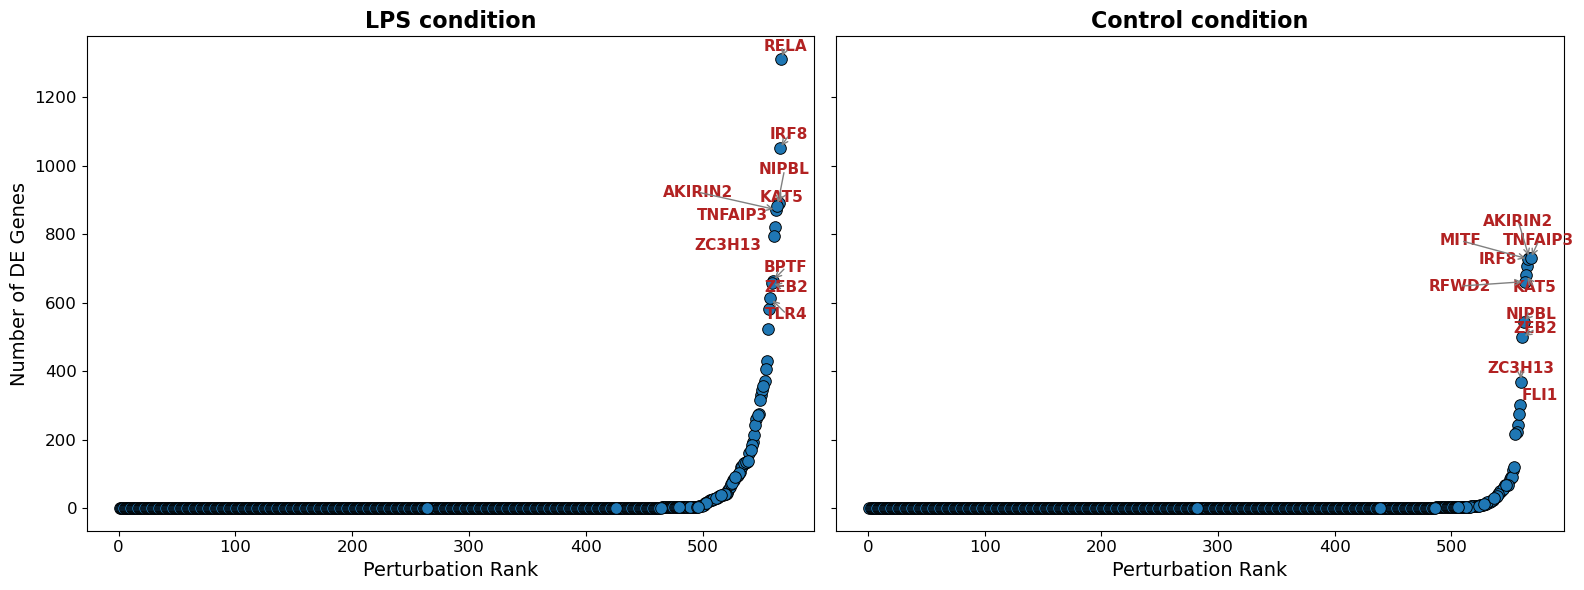

In [13]:
# Get summary statistics for each perturbation
ctrl_stats = get_de_stats(adata_ctrl)
lps_stats = get_de_stats(adata_lps)

all_stats = pd.concat([lps_stats, ctrl_stats])
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

conditions = [("Mac LPS", "LPS"), ("Mac Ctrl", "Ctrl")]
titles = ["LPS condition", "Control condition"]

for i, (cond, label) in enumerate(conditions):
    # Filter corresponding stats
    stats = all_stats[all_stats['condition'] == cond] if 'condition' in all_stats else (lps_stats if 'LPS' in cond else ctrl_stats)
    # In case 'n_total_de_genes' doesn't exist, fallback to 'n_total_de_targets'
    if 'n_total_de_genes' in stats:
        xvals = stats['n_total_de_genes'].rank(method="first")
        yvals = stats['n_total_de_genes']
        yname = "Number of DE Genes"
    else:
        xvals = stats['n_total_de_targets'].rank(method="first")
        yvals = stats['n_total_de_targets']
        yname = "Number of DE Targets"
    ax = axes[i]
    sns.scatterplot(x=xvals, y=yvals, ax=ax, s=70, color='C0', edgecolor="black", zorder=1)
    ax.set_title(titles[i], fontsize=16, fontweight="bold")
    ax.set_xlabel("Perturbation Rank", fontsize=14)
    ax.set_ylabel(yname, fontsize=14 if i==0 else 0)
    ax.tick_params(axis='both', labelsize=12)
    # Annotate top 10
    top_stats = stats.sort_values(yvals.name, ascending=False).head(10)
    
    annotation_texts = []
    for idx, row in top_stats.iterrows():
        label = str(row['contrast']) if 'contrast' in row else str(row.get('gene_id', idx))
        annotation = ax.text(
            xvals.loc[idx],
            yvals.loc[idx],
            label,
            fontsize=11,
            fontweight="bold",
            color='firebrick',
            zorder=3,
            ha='left',
            va='bottom'
        )
        annotation_texts.append(annotation)
    adjust_text(
        annotation_texts,
        ax=ax,
        only_move={'points':'y', 'texts':'y'},
        arrowprops=dict(arrowstyle='->', color='gray'),
        expand_points=(1.2, 1.6),
        expand_text=(1.2, 1.6)
    )
plt.tight_layout()
plt.show()

## Plot effects on genes of interest

In [14]:
gene_list_df = pd.read_excel("metadata/mac_target_gene_list.xlsx")
gene_list_df.columns = ['gene', 'category']
gene_list_df

,gene,category
0,TNF,Cytokine/Chemokine
1,IL1A,Cytokine/Chemokine
2,IL1B,Cytokine/Chemokine
3,IL6,Cytokine/Chemokine
4,IL12A,Cytokine/Chemokine
5,IL12B,Cytokine/Chemokine
6,IL18,Cytokine/Chemokine
7,IL10,Cytokine/Chemokine
8,IL23A,Cytokine/Chemokine
9,CCL2,Cytokine/Chemokine


In [15]:
gene_list_effects_ctrl = get_DE_results_long(
    adata_ctrl, 
    genes = gene_list_df['gene'],
)

gene_list_effects_lps = get_DE_results_long(
    adata_lps, 
    genes = gene_list_df['gene'],
)
gene_list_effects_lps.head()

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,condition,contrast
0,Mac LPS_A4GALT,CCL2,0.028093,0.219937,0.99934,False,CCL2,Mac LPS,A4GALT
1,Mac LPS_A4GALT,CCL3,0.025008,0.219411,0.99934,False,CCL3,Mac LPS,A4GALT
2,Mac LPS_A4GALT,CCL4,-0.069133,-0.678300,0.99934,False,CCL4,Mac LPS,A4GALT
3,Mac LPS_A4GALT,CCL5,-0.026573,-0.241012,0.99934,False,CCL5,Mac LPS,A4GALT
4,Mac LPS_A4GALT,CCL7,0.395043,0.633792,0.99934,False,CCL7,Mac LPS,A4GALT


In [16]:
gene_list_effects_ctrl[gene_list_effects_ctrl.adj_p_value < 0.1].value_counts('contrast').head()

contrast
TNFAIP3    10
AKIRIN2     7
KAT5        6
RFWD2       6
FLI1        5
Name: count, dtype: int64

In [17]:
gene_list_effects_lps[gene_list_effects_lps.adj_p_value < 0.1].value_counts('contrast')

contrast
TNFAIP3     18
TLR4        15
MITF        11
NIPBL       10
CD14        10
            ..
PPP1R10      1
RHOA         1
TNFRSF1A     1
TYK2         1
TRAF3        1
Name: count, Length: 65, dtype: int64

In [21]:
import numpy as np

def plot_perturbation_heatmap(
    results_df: pd.DataFrame,
    gene_col: str = 'gene_name',
    contrast_col: str = 'contrast',
    zscore_col: str = 'zscore',
    signif_col: str = 'significant',
    row_annotations: Optional[pd.Series] = None,
    figsize: Optional[tuple] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    dot_size: float = 15,
    row_cluster: bool = True,
    row_order: Optional[List[str]] = None,
    col_order: Optional[List[str]] = None,
    **kwargs
):
    """
    Plot a heatmap of perturbation effects on genes of interest.

    Genes on rows, perturbations on columns. Color = zscore (bwr, centered at 0).
    Black dots mark significant effects.

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame with differential expression results. Should contain gene, contrast, zscore, and significance columns.
    gene_col : str, default 'gene_name'
        Name of the column in results_df containing gene names (for rows).
    contrast_col : str, default 'contrast'
        Name of the column in results_df containing perturbation names (for columns).
    zscore_col : str, default 'zscore'
        Name of the column in results_df containing z-score of effect sizes.
    signif_col : str, default 'significant'
        Name of the column in results_df indicating significant effects (boolean).
    row_annotations : pd.Series, optional
        Series mapping gene names (index) to category labels, used as row color annotation.
    figsize : tuple, optional
        Tuple specifying the size of the resulting figure (width, height).
    vmin : float, optional
        Minimum value for colormap normalization.
    vmax : float, optional
        Maximum value for colormap normalization.
    dot_size : float, default 15
        Size of the dots marking significant effects.
    row_cluster : bool, default True
        If True, cluster genes (rows); if False, keep input order unless
        row_annotations is provided, in which case order by annotation.
    row_order : list of str, optional
        Explicit order for row (gene) names. If provided, disables row clustering
        and overrides annotation-based ordering.
    col_order : list of str, optional
        Explicit order for column (perturbation) names. If provided, disables
        column clustering.
    **kwargs
        Additional keyword arguments passed to seaborn.clustermap.
    """
    # If explicit orders are given, disable clustering for that axis
    if row_order is not None:
        row_cluster = False
    # Allow col_cluster kwarg but col_order takes precedence
    _col_cluster = kwargs.pop('col_cluster', True) and (col_order is None)

    # Pivot zscore values to a matrix (genes x perturbations)
    zscore_matrix = results_df.pivot_table(
        index=gene_col, columns=contrast_col, values=zscore_col, aggfunc='first'
    )
    # Pivot significance to a matching boolean matrix
    signif_matrix = results_df.pivot_table(
        index=gene_col, columns=contrast_col, values=signif_col, aggfunc='first'
    )

    # Hide effects on target itself, where gene == perturbation (index == column name)
    for gene in signif_matrix.index:
        if gene in signif_matrix.columns:
            signif_matrix.at[gene, gene] = np.nan
            if gene in zscore_matrix.columns:
                zscore_matrix.at[gene, gene] = np.nan

    # Remove perturbations with no significant genes
    has_signif = signif_matrix.any(axis=0)
    zscore_plot = zscore_matrix.loc[:, has_signif]
    signif_plot = signif_matrix.loc[:, has_signif]

    # Build row colors from annotations
    row_colors = None
    category_palette = None
    annot = None
    if row_annotations is not None:
        # Align annotations to the matrix index
        annot = row_annotations.reindex(zscore_plot.index)
        categories = annot.dropna().unique()
        palette = dict(zip(categories, sns.color_palette("tab10", len(categories))))
        row_colors = annot.map(palette).rename("Category")
        category_palette = palette

    # Determine row ordering (priority: explicit row_order > annotation-based > clustering)
    if row_order is not None:
        zscore_plot = zscore_plot.reindex(row_order)
        signif_plot = signif_plot.reindex(row_order)
        if row_colors is not None:
            row_colors = row_colors.reindex(row_order)
    elif not row_cluster and annot is not None:
        # Sort genes by annotation category, then alphabetically within category
        sort_df = (
            pd.DataFrame({'category': annot, 'gene': annot.index})
            .reset_index(drop=True)
        )
        sort_df = sort_df.sort_values(['category', 'gene'], kind='stable')
        gene_order = sort_df['gene'].tolist()
        zscore_plot = zscore_plot.reindex(gene_order)
        signif_plot = signif_plot.reindex(gene_order)
        if row_colors is not None:
            row_colors = row_colors.reindex(gene_order)

    # Apply explicit column order
    if col_order is not None:
        zscore_plot = zscore_plot.reindex(columns=col_order)
        signif_plot = signif_plot.reindex(columns=col_order)

    if figsize is None:
        figsize = (max(8, zscore_plot.shape[1] * 0.4), max(4, zscore_plot.shape[0] * 0.35))

    cg = sns.clustermap(
        zscore_plot,
        cmap='bwr',
        center=0,
        vmin=vmin,
        vmax=vmax,
        linewidths=0,
        cbar_kws={'label': 'Z-score'},
        row_colors=row_colors,
        figsize=figsize,
        row_cluster=row_cluster,
        col_cluster=_col_cluster,
        **kwargs
    )

    # Get reordered indices for dot placement
    _row_idx = cg.dendrogram_row.reordered_ind if row_cluster else np.arange(zscore_plot.shape[0])
    _col_idx = cg.dendrogram_col.reordered_ind if _col_cluster else np.arange(zscore_plot.shape[1])

    signif_reordered = signif_plot.iloc[_row_idx, _col_idx]
    for i in range(signif_reordered.shape[0]):
        for j in range(signif_reordered.shape[1]):
            if signif_reordered.iloc[i, j]:
                cg.ax_heatmap.scatter(j + 0.5, i + 0.5, color='black', s=dot_size, zorder=2)

    # Add category legend
    if category_palette is not None:
        handles = [matplotlib.patches.Patch(facecolor=c, label=l) for l, c in category_palette.items()]
        cg.ax_heatmap.legend(handles=handles, title='Category',
                             bbox_to_anchor=(1.2, 1), loc='upper left', frameon=False)

    cg.ax_heatmap.set_xlabel('Perturbation')
    cg.ax_heatmap.set_ylabel('Gene')
    cg.ax_heatmap.set_title('Perturbation effects (Z-score, dots = significant)')
    plt.tight_layout()
    fig = cg.fig
    ax = cg.ax_heatmap
    return fig, ax, zscore_plot

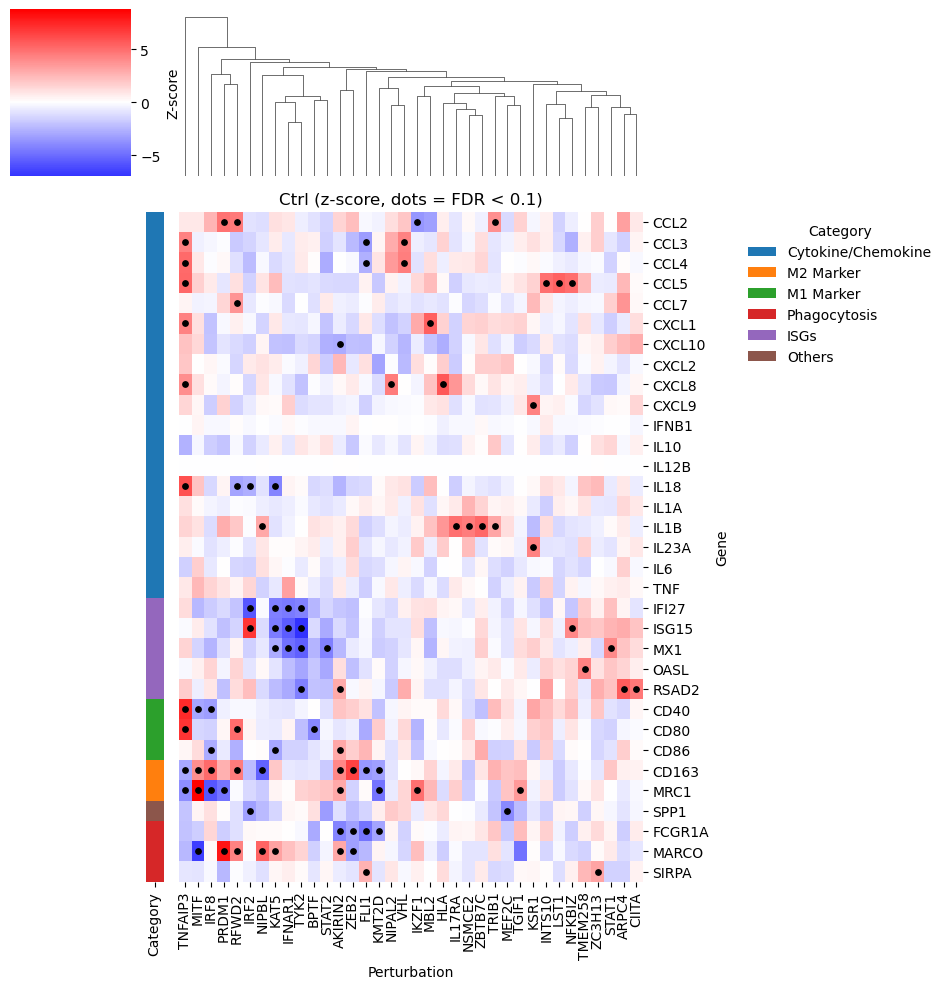

In [23]:
# Build gene -> category mapping (drop duplicates to get one category per gene)
gene_categories = gene_list_df.drop_duplicates('gene').set_index('gene')['category']

fig, ax, zscore_masked = plot_perturbation_heatmap(
    gene_list_effects_ctrl, 
    row_annotations=gene_categories,
    xticklabels=True, # force to show all labels on x-axis
    row_cluster=False, 
    # col_order = [...]  # you can specify a desired order for perturbations
    # row_order = [...] # you can specify a desired order for genes
    figsize=(10, 10)
)
ax.set_title('Ctrl (z-score, dots = FDR < 0.1)');

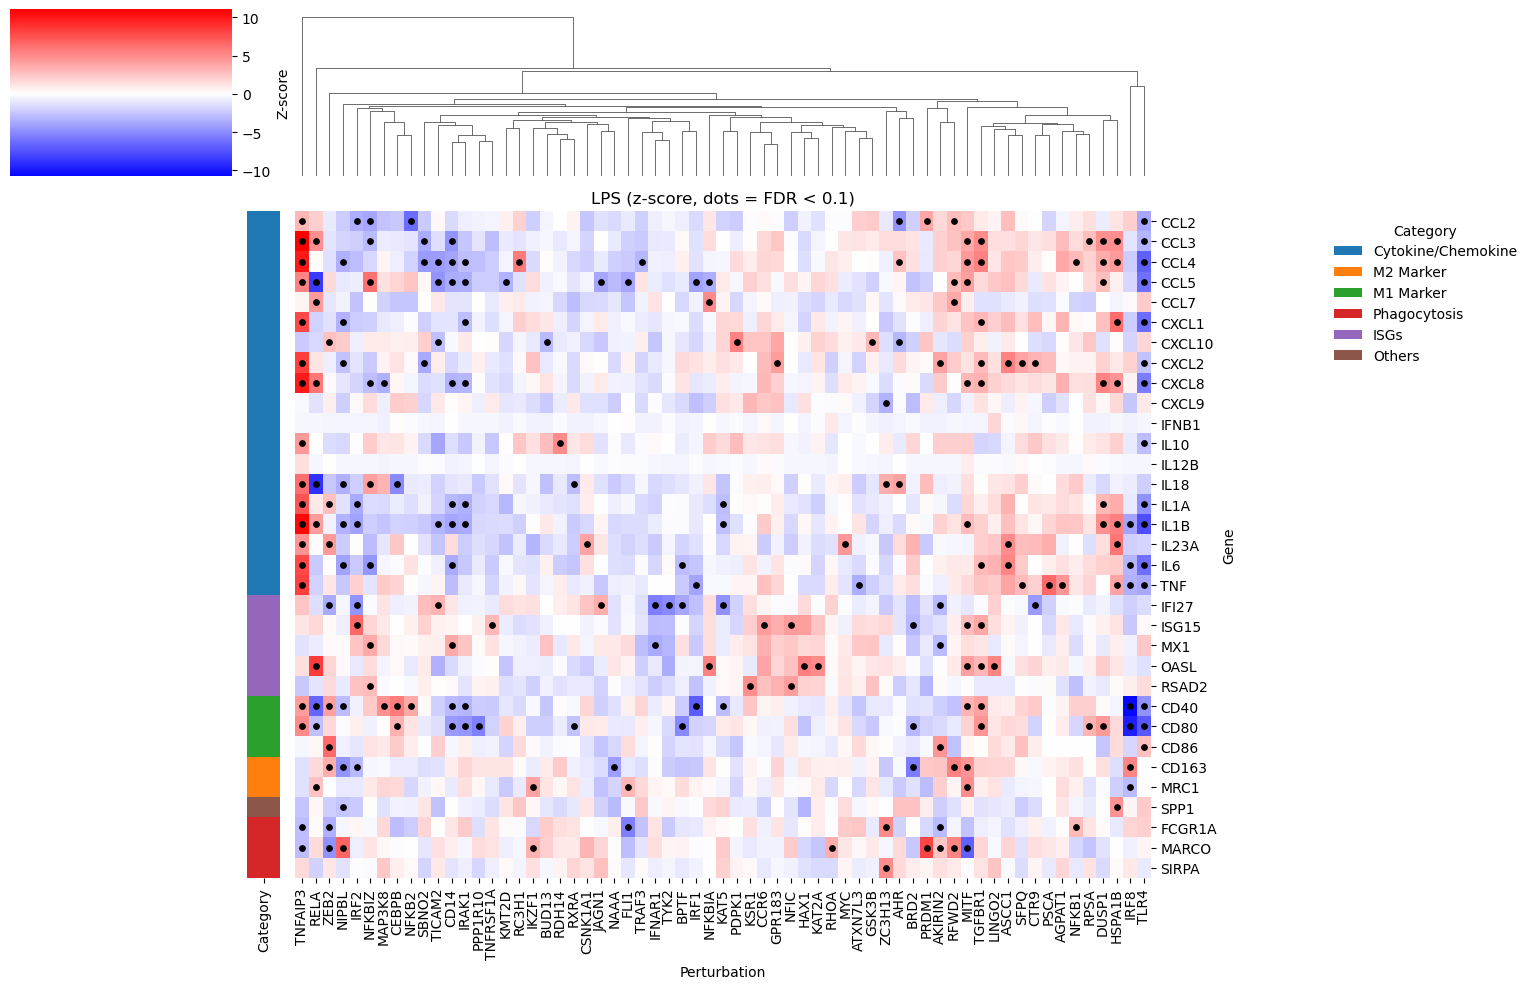

In [24]:
fig, ax, zscore_masked = plot_perturbation_heatmap(
    gene_list_effects_lps, 
    row_annotations=gene_categories,
    xticklabels=True, # force to show all labels on x-axis
    row_cluster = False,
    figsize=(16, 10)
)
ax.set_title('LPS (z-score, dots = FDR < 0.1)');

## Compare effects in multiplets vs singlets

### Compute effects in multiplets

This code can be skipped if using precomputed results from Dropbox (see object `DE_t_on_GenesOI_multiplets.t_vs_other.csv`). Skip to "Comparison".

In [7]:
import pertpy as pt
from scipy.stats import pearsonr
from scipy.sparse import issparse

Subset single cell data

In [ ]:
datadir = '/mnt/oak/users/emma/data/Macs_perturbseq/'

# Read Perturb-seq data for TNF expression 
exp_ls = ['Mac_L01_Mac_LPS', 'Mac_L02_Mac_LPS', 'Mac_L03_Mac_LPS', 'Mac_L04_Mac_LPS']
    
from tqdm import tqdm

for exp_name in tqdm(exp_ls, desc="Processing experiments"):
    lane_id = exp_name.split('_')[1]
    adata = anndata.experimental.read_lazy(f'{datadir}/{exp_name}/Mac_{lane_id}_gex_multiguide.h5ad')

    adata.obs = adata.obs.to_dataframe()
    adata.var = adata.var.to_dataframe()
    gs = np.intersect1d(adata.var_names, gene_list_df['gene'])

    # Get TNFa expression (now in adata.X instead of adata.layers['counts'])
    adata_tnf = anndata.AnnData(
        X = adata[:, gs].X.compute(),
        obs = adata.obs,
    )

    # guide_ids are now stored in adata.uns['guide_ids']
    guide_ids = pd.Index(adata.uns['guide_matrix_cols'])
    measured_KOs_perturbseq = guide_ids.str.split("-").str[0].unique()
    measured_KOs = np.append(measured_KOs_perturbseq, "NTC")

    # Filter guide_matrix (already sparse) to keep only guides targeting measured_KOs
    keep_mask = guide_ids.str.split("-").str[0].isin(measured_KOs)
    keep_guide_idx = np.where(keep_mask)[0]
    keep_guide_ids = guide_ids[keep_mask]

    adata_tnf.obsm['guide_matrix'] = adata.obsm['guide_matrix'][:, keep_guide_idx]
    adata_tnf.uns['guide_matrix_cols'] = keep_guide_ids.tolist()
    adata_tnf.write_h5ad(f'{exp_name}_genesOI_processed.h5ad')

Processing experiments: 100%|██████████| 4/4 [05:49<00:00, 87.30s/it]


In [ ]:
exp_ls = [
    'Mac_L01_Mac_LPS', 
    'Mac_L02_Mac_LPS', 'Mac_L03_Mac_LPS', 'Mac_L04_Mac_LPS']
    
ad_ls = []
for exp_name in exp_ls:
    ad = anndata.read_h5ad(f'{exp_name}_genesOI_processed.h5ad')
    ad_ls.append(ad)
    
# Get common guide_ids across all objects in ad_ls
all_gids = [set(a.uns['guide_matrix_cols']) for a in ad_ls]
common_gids = set.intersection(*all_gids)

# For each AnnData object in ad_ls, get the columns from obsm['guide_matrix'] that correspond to guide_ids in common_gids
for a in ad_ls:
    gids = a.uns['guide_matrix_cols']
    gids = pd.Index(gids)
    common_idx = gids.get_indexer_for(common_gids)
    # In case there are -1s if gids is not sorted the same as common_gids
    is_valid = common_idx != -1
    valid_common_gids = np.array(list(common_gids))[is_valid]
    valid_common_idx = common_idx[is_valid]
    # Select columns from the guide_matrix corresponding to valid_common_idx
    # If using pandas dataframe as guide_matrix:
    if hasattr(a.obsm['guide_matrix'], 'iloc'):
        a.obsm['common_guide_matrix'] = a.obsm['guide_matrix'].iloc[:, valid_common_idx]
    else:
        # If guide_matrix is numpy array or sparse matrix/scipy
        if issparse(a.obsm['guide_matrix']):
            a.obsm['common_guide_matrix'] = a.obsm['guide_matrix'][:, valid_common_idx]
        else:
            a.obsm['common_guide_matrix'] = a.obsm['guide_matrix'][:, valid_common_idx]


In [21]:
from scipy.sparse import csr_matrix,hstack

# Merge data from all lanes and guide assignments
adata_tnf = anndata.concat(ad_ls)
adata_tnf.uns['guide_ids'] = list(common_gids)

sparse_matrix = adata_tnf.obsm['common_guide_matrix']
guide_ids = adata_tnf.uns['guide_ids']

# Make design matrix mapping cells to targeted gene
guide_ids_series = pd.Series(guide_ids)
target_gene = guide_ids_series.str.split('-').str[0]

guide_to_gene = pd.DataFrame({'guide_id': guide_ids, 'target_gene': target_gene})
unique_genes = guide_to_gene['target_gene'].unique()
gene_to_indices = {gene: guide_to_gene.index[guide_to_gene['target_gene'] == gene].tolist() for gene in unique_genes}

summed_sparse_cols = []
for gene in unique_genes:
    col_indices = gene_to_indices[gene]
    summed_col = sparse_matrix[:, col_indices].sum(axis=1)
    summed_sparse_cols.append(csr_matrix(summed_col))

target_design_matrix = hstack(summed_sparse_cols, format='csr')
target_design_matrix = pd.DataFrame(target_design_matrix.toarray(), columns = unique_genes, index=adata_tnf.obs_names)
target_design_matrix[target_design_matrix != 0] = 1
target_design_matrix.head()

,FADD,YEATS4,CLIC1,NCOA5,ECSIT,NUMA1,HLA,MKX,CD47,NTC,...,UBE2F,CREB1,PLEKHB2,JAGN1,PRKCQ,DAB2,ZC3H13,TRAF2,SLC4A1,RHOA
AAACAAGCAAACAATCACAGTCTG-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAAGCAAACCCAAAACGCCGA-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAAGCAAACCCAAACAGTCTG-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AAACAAGCAAACCCAAATCATGTG-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AAACAAGCAAACCGTAACAGTCTG-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Test DE in multiplets

In [ ]:
all_res = []
for t in target_design_matrix.columns:
    adata_tnf.obs['target_oi'] = np.where(target_design_matrix[t] == 1, t, 'other')
    pds2 = pt.tl.WilcoxonTest(adata=adata_tnf, design='~target_oi')
    t_res = pds2.compare_groups(adata_tnf, column='target_oi', baseline='other', groups_to_compare=[t])
    all_res.append(t_res)

In [ ]:
res = pd.concat(all_res)
res['gene_name'] = [gs[int(x)] for x in res['variable']]
res['target_gene'] = res['comparison'].str.split("_vs").str[0]
multiplets_effects_df = res.rename(columns = {'target_gene':'contrast'})
mean_counts = np.array(adata_tnf.X.mean(axis=0)).flatten()
mean_counts = pd.Series(mean_counts, index=gs)
n_cells_target = target_design_matrix.sum()
multiplets_effects_df['n_cells_target'] = [n_cells_target[x] for x in multiplets_effects_df['contrast']]
multiplets_effects_df['mean_expr_gene'] = [mean_counts[x] for x in multiplets_effects_df['gene_name']]
multiplets_effects_df.to_csv("results/DE_t_on_GenesOI_multiplets.t_vs_other.csv")

### Comparison

In [25]:
multiplets_effects_df = pd.read_csv("results/DE_t_on_GenesOI_multiplets.t_vs_other.csv", index_col=0)
multiplets_effects_df.head()

,variable,p_value,log_fc,comparison,adj_p_value,gene_name,contrast,n_cells_target,mean_expr_gene
28,28,0.000001,0.148163,FADD_vs_other,0.000037,MX1,FADD,3034,3.898267
12,12,0.000067,0.103848,FADD_vs_other,0.001131,CXCL8,FADD,3034,115.953400
30,30,0.000238,0.289519,FADD_vs_other,0.002694,RSAD2,FADD,3034,1.684946
8,8,0.000614,0.126421,FADD_vs_other,0.005220,CD86,FADD,3034,1.115595
1,1,0.001229,0.082644,FADD_vs_other,0.008357,CCL3,FADD,3034,32.451645


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4894: RuntimeWarning: invalid value encountered in subtract
  ym = y - ymean


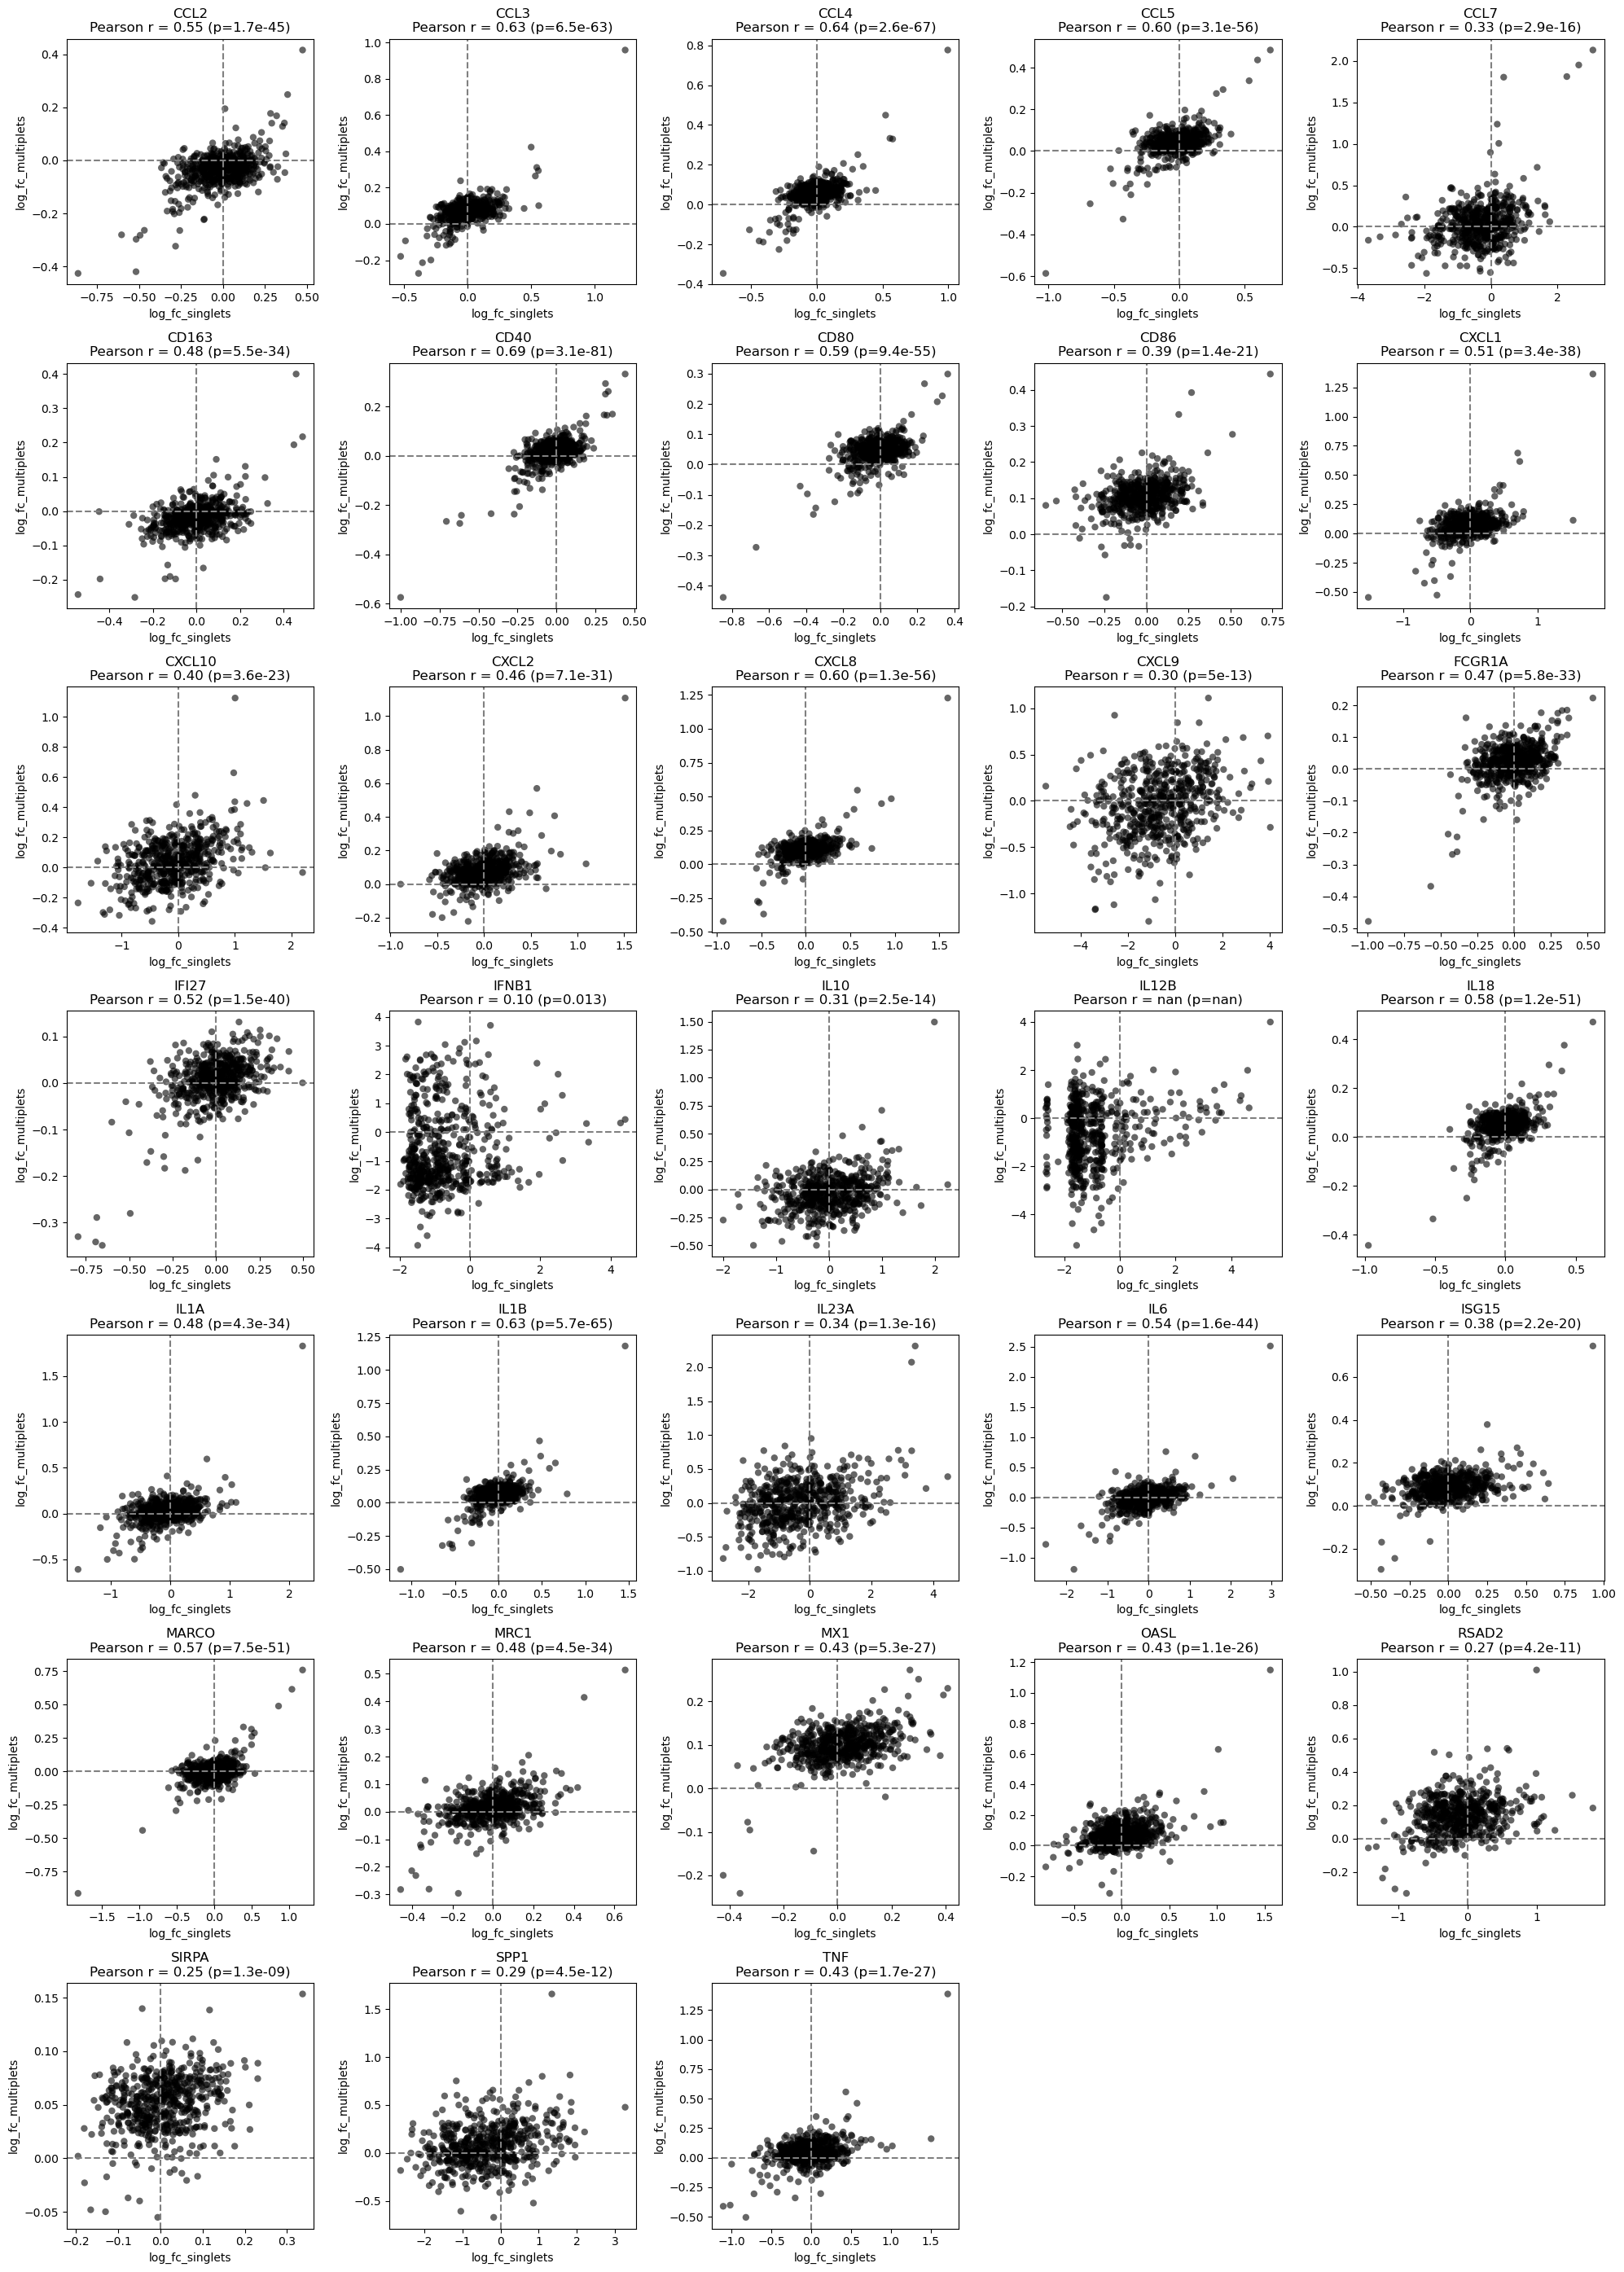

In [28]:
pl_df = pd.merge(
    gene_list_effects_lps[['gene_name', 'contrast', 'log_fc', 'zscore']],
    multiplets_effects_df,
    on=['gene_name', 'contrast'],
    suffixes=('_singlets', '_multiplets')
)

unique_genes = pl_df['gene_name'].unique()
n_genes = len(unique_genes)

# Prepare to save correlation results
cor_results = []

# Determine the layout of subplots (try to make it roughly square)
n_cols = min(5, n_genes)
n_rows = int(np.ceil(n_genes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4), squeeze=False)
axes = axes.flatten()

for idx, gene in enumerate(unique_genes):
    ax = axes[idx]
    data_gene = pl_df[pl_df['gene_name'] == gene]
    sns.scatterplot(
        data=data_gene,
        x='log_fc_singlets',
        y='log_fc_multiplets',
        edgecolor='none', 
        alpha=0.6,
        color='black',
        ax=ax
    )
    ax.axhline(y=0, linestyle='--', color='grey')
    ax.axvline(x=0, linestyle='--', color='grey')
    if len(data_gene) > 1:
        corr_coef, p_val = pearsonr(data_gene['log_fc_singlets'], data_gene['log_fc_multiplets'])
        cor_results.append({"gene_name": gene, "pearson_r": corr_coef, "p_value": p_val, "n_points": len(data_gene)})
        ax.set_title(f"{gene}\nPearson r = {corr_coef:.2f} (p={p_val:.2g})")
    else:
        cor_results.append({"gene_name": gene, "pearson_r": None, "p_value": None, "n_points": len(data_gene)})
        ax.set_title(f"{gene}\nNot enough data for correlation")
    ax.set_xlabel('log_fc_singlets')
    ax.set_ylabel('log_fc_multiplets')

# Hide any empty subplots
for i in range(len(unique_genes), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Save correlations and p-values table
cor_results_df = pd.DataFrame(cor_results)
cor_results_df.to_csv("results/singlet_multiplet_pearson_correlations.csv", index=False)

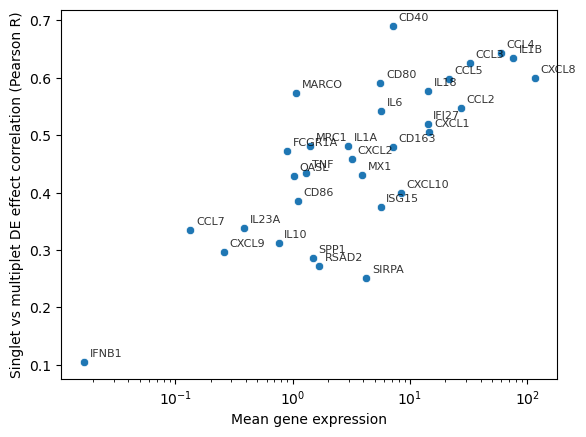

In [34]:
mean_counts = multiplets_effects_df[['mean_expr_gene', 'gene_name']].drop_duplicates().set_index('gene_name')['mean_expr_gene'].to_dict()
cor_results_df['mean_expr_gene'] = [mean_counts[x] for x in cor_results_df['gene_name']]

ax = sns.scatterplot(data=cor_results_df, x='mean_expr_gene', y='pearson_r')
plt.xscale('log')
plt.xlabel('Mean gene expression')
plt.ylabel('Singlet vs multiplet DE effect correlation (Pearson R)')
for _, row in cor_results_df.iterrows():
    ax.annotate(row['gene_name'], (row['mean_expr_gene'], row['pearson_r']),
                textcoords="offset points", xytext=(4, 4), ha='left', fontsize=8, alpha=0.8)
